## Workplace Diversity

### Business Problem

There has been lots of talking about diversity in the workplace, especially in technology.Analyze internal data about employees and see whether results suggest that the company is treating its employees fairly.

### Roadmap

1. Load and Inspect Data
2. EDA on Workplace Data
3. Apply Regression to predict Salary and see if employees are paid fairly.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

%matplotlib inline

Dataset:
Company heirarchy: Includes employee id and boss id along with department<br>
Employee: Includes information such as salary, sex, years of experience for very employee

In [8]:
company = pd.read_csv("company_heirarchy.csv")
company['boss_id'] = company['boss_id'].astype('Int64')

In [3]:
company.head()

,employee_id,boss_id,dept
0,46456,175361,sales
1,104708,29733,HR
2,120853,41991,sales
3,142630,171266,HR
4,72711,198240,sales


In [5]:
company.shape

(10000, 3)

In [6]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  10000 non-null  int64 
 1   boss_id      9999 non-null   Int64 
 2   dept         10000 non-null  object
dtypes: Int64(1), int64(1), object(1)
memory usage: 244.3+ KB


In [7]:
company.isna().sum()

employee_id    0
boss_id        1
dept           0
dtype: int64

In [9]:
employee = pd.read_csv("employee.csv")
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [10]:
employee.isnull().sum()

employee_id       0
signing_bonus     0
salary            0
degree_level      0
sex               0
yrs_experience    0
dtype: int64

In [11]:
employee.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [12]:
employee.shape

(10000, 6)

# Question 1
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

Individual Contributors (IC) - they don't manage anyone
Middle Managers (MM) - they are the direct bosses of IC
Directors (D) - they are the direct bosses of MM
VP - D direct bosses
Executives (E) - VP direct bosses
CEO - The direct boss of E.

In [13]:
level = ['CEO','E','VP','D','MM','IC']

In [14]:
company.loc[company.boss_id.isnull(),'level'] = 'CEO'

In [15]:
company.loc[company.boss_id.isnull()]

,employee_id,boss_id,dept,level
2427,61554,<NA>,CEO,CEO


In [16]:
for i in range(len(level)-1):
    boss_level = level[i]
    emp_level = level[i+1]
    boss_id = company[company['level'] == boss_level]['employee_id']
    company.loc[company.boss_id.isin(boss_id),'level'] = emp_level

In [17]:
company.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Question 2
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [18]:
company['total'] = 0


In [19]:
for level in ['IC','MM','D','VP','E']:
    emp_id = company[company['level'] == level]['employee_id']
    boss_id = company[company['level'] == level]['boss_id']
    
    for b_id,e_id in zip(boss_id,emp_id):
        
        e_cnt = int(1+company.loc[company.employee_id == e_id,'total'])
        b_cnt = int(company.loc[company.employee_id == b_id,'total'])
        company.loc[company.employee_id == b_id,'total'] = e_cnt+b_cnt

CEO manages 9999 employees

In [20]:
company.loc[company.level == 'CEO','total']

2427    9999
Name: total, dtype: int64

# Question 3
Build a model to predict the salary of each employee.

Merge employee and company data to have a full dataset

In [21]:
data = pd.merge(company,employee,how = 'left',on = 'employee_id')
data.head()

,employee_id,boss_id,dept,level,total,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361,sales,IC,0,0,213000.0,Bachelor,M,5
1,104708,29733,HR,IC,0,0,79000.0,Bachelor,F,3
2,120853,41991,sales,IC,0,0,199000.0,High_School,M,5
3,142630,171266,HR,MM,16,0,143000.0,PhD,F,13
4,72711,198240,sales,IC,0,0,235000.0,Master,M,1


No obvious outlieres found.

In [24]:
data.describe()

,employee_id,boss_id,total,signing_bonus,salary,yrs_experience
count,10000.000000,9999.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,100001.855800,103299.980498,4.87540,0.301400,189111.800000,3.875200
std,57500.488641,57508.798817,114.47918,0.458889,88973.796898,3.107409
min,40.000000,79.000000,0.00000,0.000000,60000.000000,1.000000
25%,50574.500000,55883.000000,0.00000,0.000000,110000.000000,2.000000
50%,99244.500000,102712.000000,0.00000,0.000000,182000.000000,3.000000
75%,149748.500000,152288.000000,0.00000,1.000000,255000.000000,5.000000
max,199956.000000,199950.000000,9999.00000,1.000000,700000.000000,34.000000


#### Distribution of target variable i.e Salary

Salary is right skewed so we applied log transformation to correct for it.

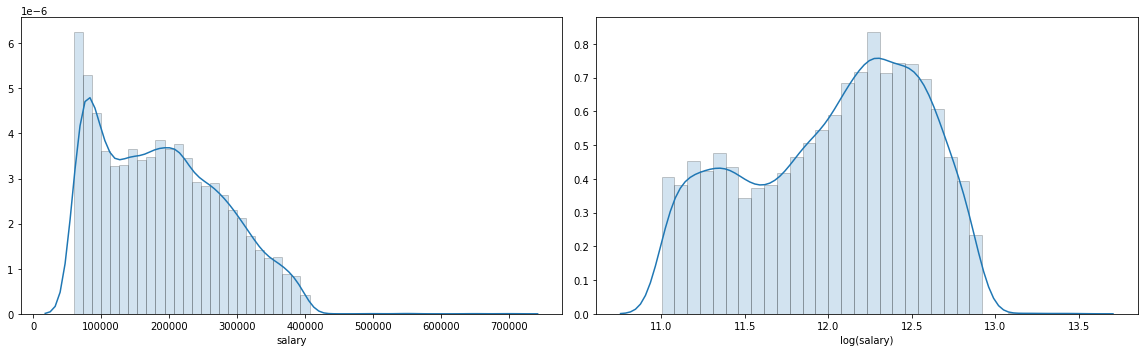

In [22]:
#Distribution of Salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

### Exploratory Analysis of Variables 

#### Signing Bonus vs Salary

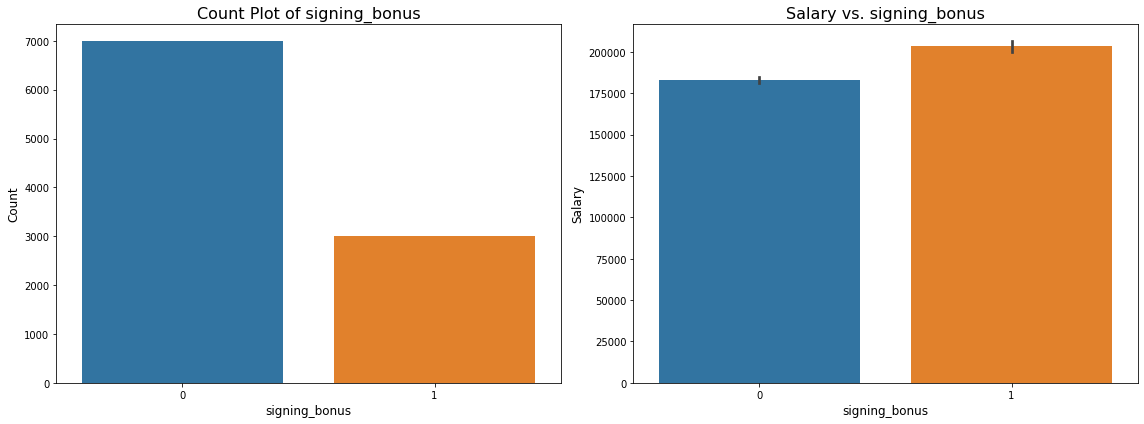

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. There are fewer employees who receive a signing bonus.
2. Salaries are usually high for employees who get sign-on bonus. Maybe signing bonus is only offered at higher levels.


#### Department vs Salary

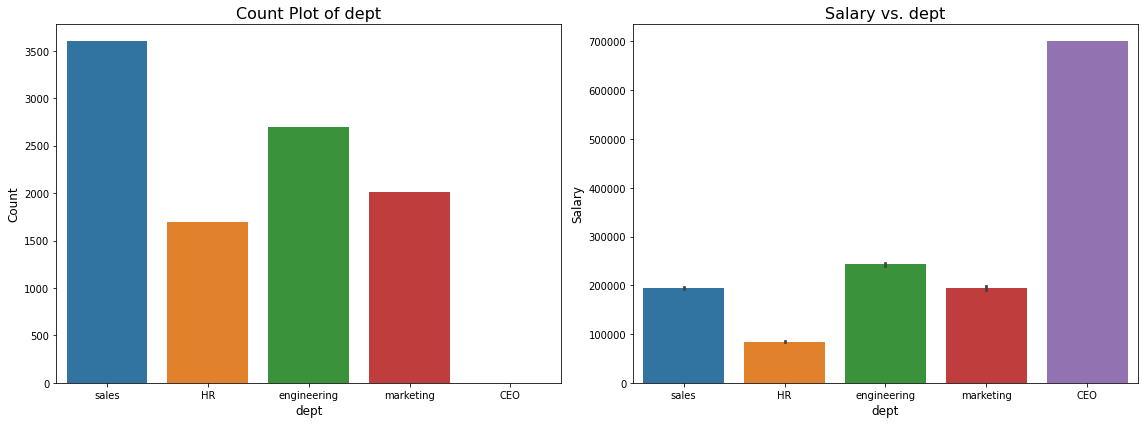

In [28]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. Sales has highest number of employees, followed by engineering and marketing
2. Keeping CEO salary aside, Engineering department has the highest salary.

#### Education Level vs Salary

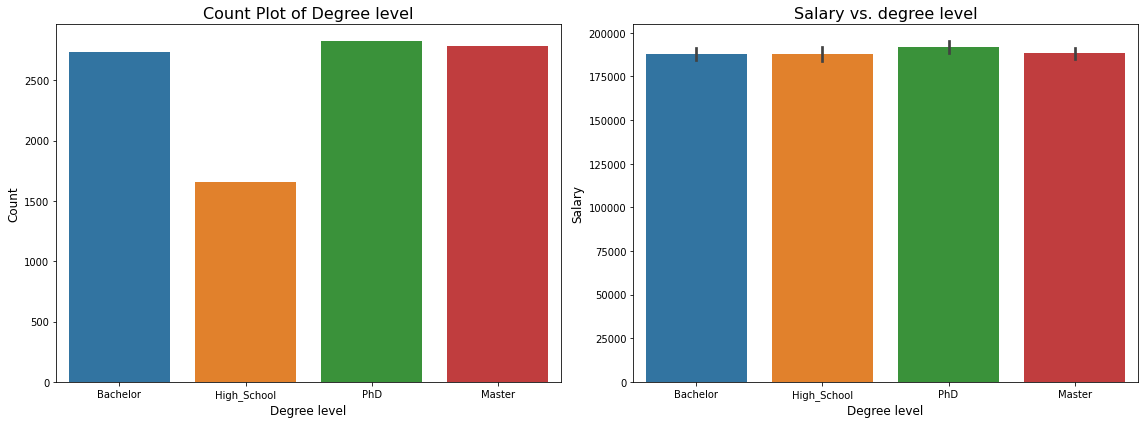

In [69]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('Degree level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Degree level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('Degree level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree level', fontsize=16)
plt.tight_layout()
plt.show()

#### Results:

1. There are fewer employees with just a high school degree. Most employees have Bachelor, Master and even a PHD.
2. Every employee is paid almost the same regardless of the level of education. An employee with a high school degree is paid as much as an employee with a Bachelor degree.

#### Gender vs Salary

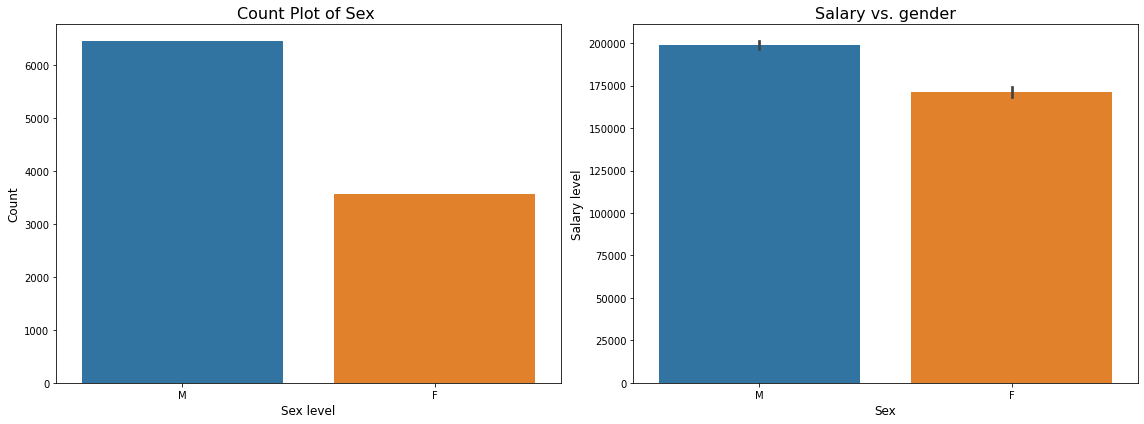

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('Sex level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Sex ', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('Sex', fontsize=12)
ax[1].set_ylabel('Salary level', fontsize=12)
ax[1].set_title('Salary vs. gender', fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. There are lesser number of female employees than male employees.
2. The mean salary of female employees is less than that of male co-workers.

Let's investigate which department or level does this difference in salary comes from?

<Figure size 720x720 with 0 Axes>

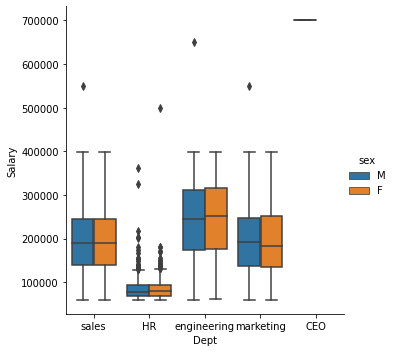

In [72]:
plt.figure(figsize=(10,10))
g = sns.factorplot("dept", "salary", "sex", data=data, kind="box")
g.set_axis_labels("Dept", "Salary")

<Figure size 720x720 with 0 Axes>

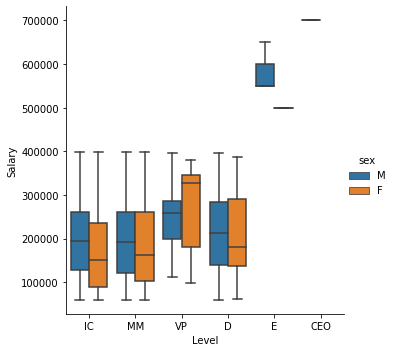

In [73]:
plt.figure(figsize=(10,10))
g = sns.factorplot("level", "salary", "sex", data=data, kind="box")
g.set_axis_labels("Level", "Salary")

#### Results
 Looks like there are no females at executive level.Hence, the difference between male and female salaries.

#### Number of years of experience vs Salary

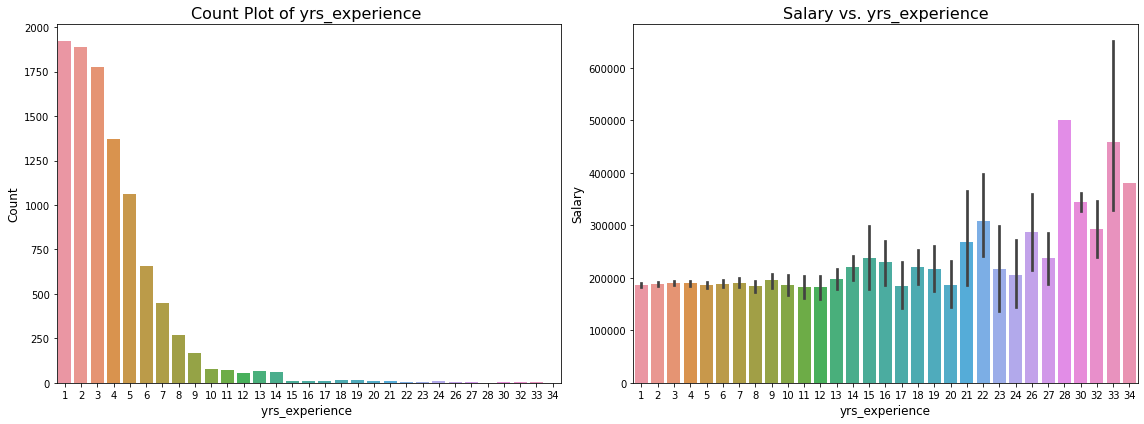

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience ', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience ', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. A lot of the employees have 1-2 years of experience.
2. There appears to be more difference in the average amount of salary as the number of years of experience increases.

#### Level vs Salary

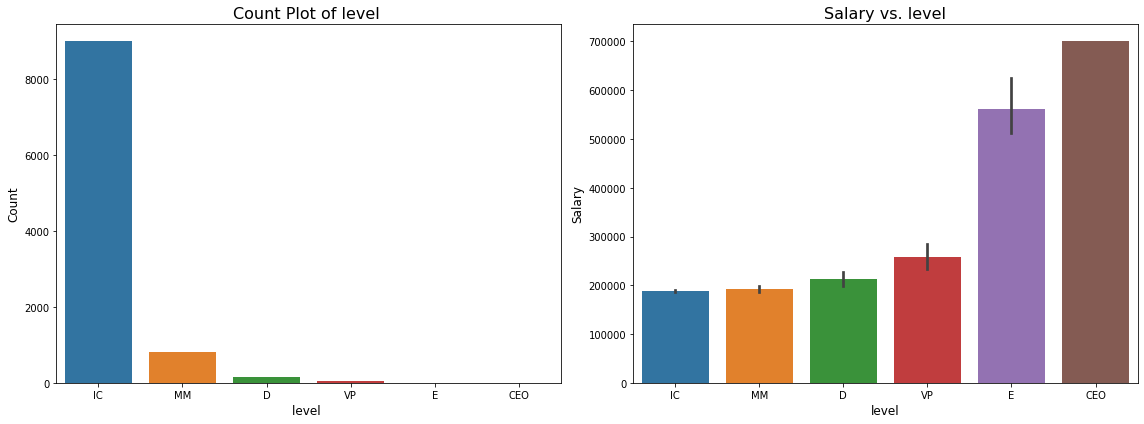

In [82]:
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0],order = orders)
ax[0].set_xlabel('level ', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level ', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1],order = orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. There are a lot of employees at Individual Contributer Level. Very few at Management and Director level.
2. The average salary is consistent till VP level but is very high at Executive level.

### Model Building

#### Feature Engineering

Remove CEO Salary as it's an outlier.

In [38]:
#Prediction
data_cp = data
#Remove CEO as high salary will skew the data
data_cp = data_cp[data_cp.dept != 'CEO']


Assigning Integer Categories to Categorical Variables.<br>
Sex: Male is 1 and Female is 0<br>
Degree Level: 1 for high school, 2 for bachelor, 3 for Master, 4 for PHD
Level: 0 for IC, 1 for MM, 2 for Director, 3 for VP, 4 for Executive


In [39]:
data_cp['sex'] = (data_cp['sex'] == 'M').astype(int)
data_cp['degree_level'] = data_cp['degree_level'].apply(lambda x: ['High_School','Bachelor','Master','PhD'].index(x))

data_cp.head()


,employee_id,boss_id,dept,level,total,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361,sales,IC,0,0,213000.0,1,1,5
1,104708,29733,HR,IC,0,0,79000.0,1,0,3
2,120853,41991,sales,IC,0,0,199000.0,0,1,5
3,142630,171266,HR,MM,16,0,143000.0,3,0,13
4,72711,198240,sales,IC,0,0,235000.0,2,1,1


In [40]:
data_cp['level'] = data_cp['level'].apply(lambda x: ['IC','MM',"D","VP","E"].index(x))


In [41]:
data_cp.level.value_counts()

0    9000
1     800
2     160
3      35
4       4
Name: level, dtype: int64

Removing Id's from the dataset

In [42]:
# drop useless features
data_cp = data_cp.drop(labels=['employee_id', 'boss_id','total'], axis=1)
data_cp.head()

,dept,level,signing_bonus,salary,degree_level,sex,yrs_experience
0,sales,0,0,213000.0,1,1,5
1,HR,0,0,79000.0,1,0,3
2,sales,0,0,199000.0,0,1,5
3,HR,1,0,143000.0,3,0,13
4,sales,0,0,235000.0,2,1,1


Label Encode Departments

In [43]:
dept_encoder = LabelEncoder()
data_cp['dept'] = dept_encoder.fit_transform(data_cp['dept'])

Classes: 0 for HR, 1 for Engineering, 2 for Marketing and 3 for Sales

In [45]:
dept_encoder.classes_

array(['HR', 'engineering', 'marketing', 'sales'], dtype=object)

In [46]:
data_cp.head()

,dept,level,signing_bonus,salary,degree_level,sex,yrs_experience
0,3,0,0,213000.0,1,1,5
1,0,0,0,79000.0,1,0,3
2,3,0,0,199000.0,0,1,5
3,0,1,0,143000.0,3,0,13
4,3,0,0,235000.0,2,1,1


In [47]:
categorical = ['dept','level','signing_bonus','degree_level','sex']
data_cp[categorical] = data_cp[categorical].astype('category')

data_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   dept            9999 non-null   category
 1   level           9999 non-null   category
 2   signing_bonus   9999 non-null   category
 3   salary          9999 non-null   float64 
 4   degree_level    9999 non-null   category
 5   sex             9999 non-null   category
 6   yrs_experience  9999 non-null   int64   
dtypes: category(5), float64(1), int64(1)
memory usage: 283.9 KB


#### Train-Test Split 

25% for testing and 75% for Training

In [48]:
#Training test split
X = data_cp.drop('salary',axis = 1)
Y = data_cp['salary']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(7499, 2500, 7499, 2500)

In [49]:
#Check randomization
print(X_train.level.value_counts())
print(X_test.level.value_counts())


0    6752
1     607
2     112
3      27
4       1
Name: level, dtype: int64
0    2248
1     193
2      48
3       8
4       3
Name: level, dtype: int64


We can see that, after splitting, even the smallest group 'level=4' (i.e., Executive level), has representives in **both** groups. Hence, the splitting is valid to be used to train and evaluate.

Apply log tranform to the target variable to correct for skewness

In [50]:
# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

### LightGBM Model Training

We will use LightGBM for Regression for the following reasons:
1. Faster training speed and higher efficiency
2. Lower memory usage
3. Better accuracy
4. Support of parallel and GPU learning
5. Capable of handling large-scale data
6. Can be used for classification and regression

In [51]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical)

In [52]:
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

Best rounds:	 689


We can see how root mean square decreases as number of boosting rounds increases

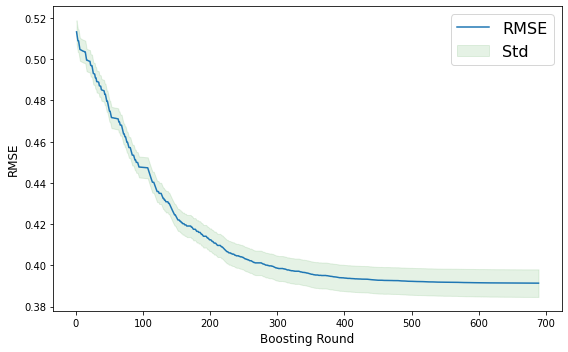

In [53]:
rmse = np.array(history['rmse-mean'])
std = np.array(history['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.fill_between(range(1, best_round + 1), rmse + std, rmse - std, 
                alpha=0.1, color='g', label='Std')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

#### Model Prediction

In [54]:
clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

In [55]:
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.3973460855833569
Test R2:	 0.42144628054628874


Residuals have a normal distribution

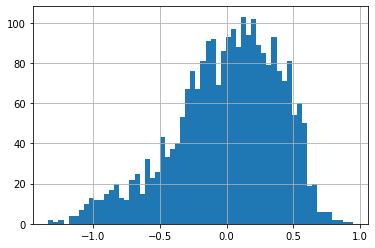

In [56]:
#Plotting residuals
(y_test - pred).hist(bins=60)

# Question 4
Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

#### Feature Importance plot

Years of experience, Degree level and Department are important when predicting the Salary of an employee

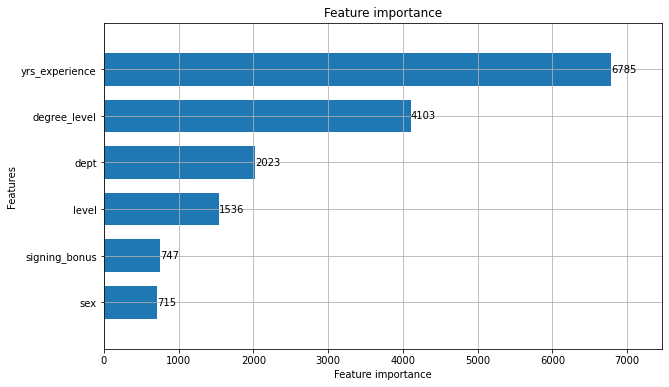

In [58]:
features = clf.feature_name()
importance = clf.feature_importance()
fig,ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf,ax = ax,height = 0.7)
plt.show()

#### Bias Validation

To see if an employee is overpaid or underpaid, we will run our model on the entire dataset. If the difference between true salary and predicted salary is negative then employee is underpaid and if it is positive then employee is overpaid. We will name this new field as bias.

In [59]:
#yrs_experience,degree_level.dept are important factors.
d_train_full = lgb.Dataset(data=X, label=Y, free_raw_data=False, 
                      categorical_feature=categorical)

In [60]:
clf = lgb.train(params, train_set=d_train_full, num_boost_round=best_round)
ypred = clf.predict(X)

In [61]:
predresult = pd.DataFrame({'ytrue': Y,'ypred': ypred})
predresult

,ytrue,ypred
0,213000.0,193163.952946
1,79000.0,86287.177237
2,199000.0,193016.108998
3,143000.0,117774.583871
4,235000.0,193586.536794
...,...,...
9995,185000.0,246637.185532
9996,70000.0,82910.381741
9997,346000.0,233063.441529
9998,304000.0,236621.258811


In [62]:
predresult['bias'] = predresult.ytrue - predresult.ypred

In [63]:
# if bias >0, means, that employee is over paid
# otherwise, bias<0, means that employee is under paid
predresult = predresult.join(data_cp)
predresult.head() 

,ytrue,ypred,bias,dept,level,signing_bonus,salary,degree_level,sex,yrs_experience
0,213000.0,193163.952946,19836.047054,3,0,0,213000.0,1,1,5
1,79000.0,86287.177237,-7287.177237,0,0,0,79000.0,1,0,3
2,199000.0,193016.108998,5983.891002,3,0,0,199000.0,0,1,5
3,143000.0,117774.583871,25225.416129,0,1,0,143000.0,3,0,13
4,235000.0,193586.536794,41413.463206,3,0,0,235000.0,2,1,1


Bias is normally distributed

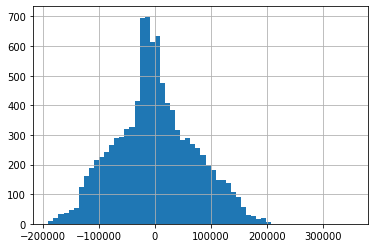

In [64]:
predresult.bias.hist(bins=60)

Let's look at the bias in salary, level and by gender

Text(0, 0.5, 'bias')

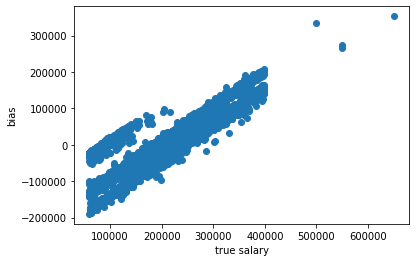

In [66]:
plt.scatter(predresult.salary,predresult.bias)
plt.xlabel("true salary")
plt.ylabel("bias")
#from above plot, we can see that, employee with high salary are more likely to be overpaid

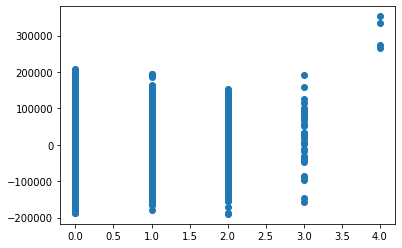

In [67]:
plt.scatter(predresult.level,predresult.bias)

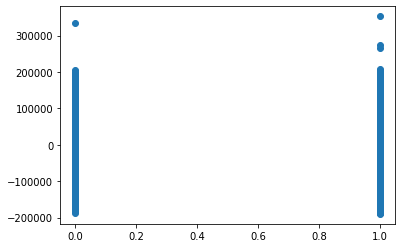

In [68]:
plt.scatter(predresult.sex,predresult.bias)

#### Results:

1. In general, the company treats it's employees fairly. The difference in salary between different levels and gender seems fair. 

2. The only bias that does exists, is that senior management is likely to be overpaid given the number of years of experience. Higher the level, more likely to be overpaid.